In [1]:
import numpy as np 
import pandas as pd 
import os 
import sys 
import torch
import torchvision

# Importing the dataset

In [2]:
fish_categories = []
path = '../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'
for directory in os.listdir(path):
    if '.' not in directory:
        fish_categories.append(directory)
        
print(fish_categories)

['Hourse Mackerel', 'Black Sea Sprat', 'Sea Bass', 'Red Mullet', 'Trout', 'Striped Red Mullet', 'Shrimp', 'Gilt-Head Bream', 'Red Sea Bream']


In [3]:
image_directory = {}
for i in fish_categories:
    image_directory[i] = [os.path.join(path,i,i,j) for j in  os.listdir(os.path.join(path,i,i))]

In [4]:
file_category = []
file_name = []
for i in image_directory.keys():
    for j in image_directory[i]:
        file_category.append(i)
        file_name.append(j)

In [5]:
data = {'categories':file_category,'file_name':file_name}

In [6]:
image_df = pd.DataFrame(data)
image_df.head()

,categories,file_name
0,Hourse Mackerel,../input/a-large-scale-fish-dataset/Fish_Datas...
1,Hourse Mackerel,../input/a-large-scale-fish-dataset/Fish_Datas...
2,Hourse Mackerel,../input/a-large-scale-fish-dataset/Fish_Datas...
3,Hourse Mackerel,../input/a-large-scale-fish-dataset/Fish_Datas...
4,Hourse Mackerel,../input/a-large-scale-fish-dataset/Fish_Datas...


In [7]:
import PIL
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset

Red Mullet
../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Red Mullet/Red Mullet/00541.png


Text(0.5, 1.0, 'Red Mullet')

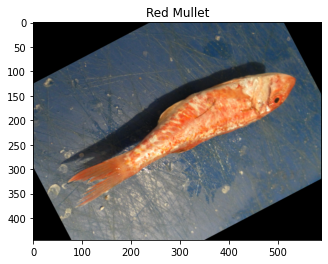

In [8]:
import matplotlib.pyplot as plt

x = image_df.sample()
random_category = x.categories.values[0]
random_file_name = x.file_name.values[0]
print(random_category)
print(random_file_name)
img = PIL.Image.open(random_file_name)
plt.imshow(img)
plt.title(random_category)


In [9]:
img_array = np.array(img)
print(img_array.shape)
img_array_transposed = np.transpose(img_array,(2,0,1))
print(img_array_transposed.shape)

(445, 590, 3)
(3, 445, 590)


In [10]:
str_to_int = {}
for i in range(len(fish_categories)):
    str_to_int[fish_categories[i]]=i
    
print(str_to_int)

{'Hourse Mackerel': 0, 'Black Sea Sprat': 1, 'Sea Bass': 2, 'Red Mullet': 3, 'Trout': 4, 'Striped Red Mullet': 5, 'Shrimp': 6, 'Gilt-Head Bream': 7, 'Red Sea Bream': 8}


In [11]:
int_to_str = dict([(value, key) for key, value in str_to_int.items()])
print(int_to_str)

{0: 'Hourse Mackerel', 1: 'Black Sea Sprat', 2: 'Sea Bass', 3: 'Red Mullet', 4: 'Trout', 5: 'Striped Red Mullet', 6: 'Shrimp', 7: 'Gilt-Head Bream', 8: 'Red Sea Bream'}


# Building the Dataset Class

In [12]:
transform = T.Compose([T.Resize(256),T.CenterCrop(224),T.Resize(64),T.ToTensor(),T.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])

In [13]:
class FishDataset(Dataset):
    def __init__(self,data,path,transform=None):
        self.data = data
        self.path = path
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        image_path = self.data.file_name[idx]
        image = PIL.Image.open(image_path)
        category_name = self.data.categories[idx]
        label = str_to_int[category_name]
        if self.transform:
            image = self.transform(image)
            
        
#         image = torch.Tensor(np.transpose(np.array(image),(2,0,1)))
        return image,label
        

In [14]:
dataset = FishDataset(data=image_df,path=path,transform=transform)

torch.Size([3, 64, 64])


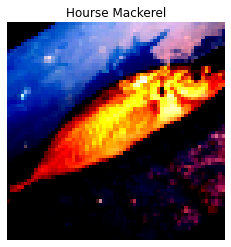

In [15]:
img, lab = dataset[34]
print(img.shape)
plt.imshow(img.numpy().transpose((2,1,0)))
plt.title(fish_categories[int(lab)])
plt.axis('off')
plt.show()

In [16]:
train_data,test_data = torch.utils.data.random_split(dataset,[7000,2000])
valid_data,test_data = torch.utils.data.random_split(test_data,[1000,1000])

In [17]:
trainloader = DataLoader(train_data,batch_size=64,shuffle=True)
validloader = DataLoader(valid_data,batch_size=64,shuffle=False)
testloader = DataLoader(test_data,batch_size=1,shuffle=False)

# Building the Neural Network

In [18]:
import torch.nn as nn
import torch.nn.functional as F

In [19]:
cuda_available = torch.cuda.is_available()

if cuda_available:
    print('True')
else:
    print('False')

True


In [20]:
print(len(fish_categories))

9


In [21]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(3,16,3)
        self.conv2 = nn.Conv2d(16,32,3)
        self.conv3 = nn.Conv2d(32,64,3)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64*6*6,500)
        self.fc2 = nn.Linear(500,9)
    
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1,64*6*6)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [22]:
model =  Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=2304, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=9, bias=True)
)


In [23]:
if cuda_available:
    model.cuda()

# Training and Testing the Model

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [25]:
n_epochs = 15
valid_loss_min = np.Inf

for epoch in range(1,n_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0
    
    model.train()
    
    for data,target in trainloader:
        if cuda_available:
            data,target = data.cuda(),target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output,target)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()*data.size(0)
    
    model.eval()
    
    for data,target in validloader:
        if cuda_available:
            data,target = data.cuda(),target.cuda()
        output = model(data)
        loss = criterion(output,target)
        valid_loss+=loss.item()*data.size(0)
        
    train_loss = train_loss/len(trainloader.sampler)
    valid_loss = valid_loss/len(validloader.sampler)
    
    print('Epoch: {} , Training Loss: {:.6f}, Validation Loss: {:.6f}'.format(epoch,train_loss,valid_loss))
    
    if valid_loss<=valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_fish.pt')
        valid_loss_min = valid_loss
        

Epoch: 1 , Training Loss: 2.120657, Validation Loss: 1.745368
Validation loss decreased (inf --> 1.745368).  Saving model ...
Epoch: 2 , Training Loss: 1.571781, Validation Loss: 1.305519
Validation loss decreased (1.745368 --> 1.305519).  Saving model ...
Epoch: 3 , Training Loss: 1.298344, Validation Loss: 1.096612
Validation loss decreased (1.305519 --> 1.096612).  Saving model ...
Epoch: 4 , Training Loss: 1.177354, Validation Loss: 1.062189
Validation loss decreased (1.096612 --> 1.062189).  Saving model ...
Epoch: 5 , Training Loss: 1.073802, Validation Loss: 0.907049
Validation loss decreased (1.062189 --> 0.907049).  Saving model ...
Epoch: 6 , Training Loss: 0.972676, Validation Loss: 0.782356
Validation loss decreased (0.907049 --> 0.782356).  Saving model ...
Epoch: 7 , Training Loss: 0.912495, Validation Loss: 0.732894
Validation loss decreased (0.782356 --> 0.732894).  Saving model ...
Epoch: 8 , Training Loss: 0.879835, Validation Loss: 0.761567
Epoch: 9 , Training Loss: 

## Loading the saved state

In [26]:
model.load_state_dict(torch.load('model_fish.pt'))

<All keys matched successfully>

## Calculating test loss

In [27]:
test_loss = 0.0 
y_pred = []
y_label = []
model.eval()
for data,target in testloader:
    if cuda_available:
        data,target = data.cuda(),target.cuda()
    output = model(data)
    loss = criterion(output,target)
    _,pred = torch.max(output,dim=1)
    pred = pred.cpu().item()
    y_pred.append(pred)
    y_label.append(target.cpu().item())
    test_loss+=loss.item()*data.size(0)
    
test_loss = test_loss/len(testloader.sampler)
print('Test loss : {:.6f}'.format(test_loss))
    
    

Test loss : 0.617896


# Metrics and Evaluation

In [28]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

## Accuracy

In [29]:
accuracy = accuracy_score(y_label,y_pred)
print('Accuracy : {:.3f} %'.format(accuracy*100))

Accuracy : 76.200 %


## Confusion Matrix

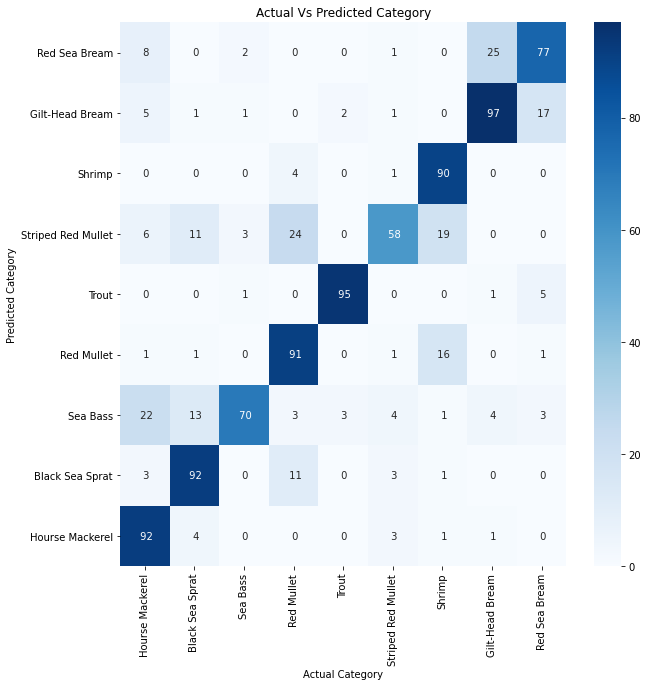

In [30]:
import seaborn as sns
fig = plt.figure(figsize=(10,10))
cm = confusion_matrix(y_label,y_pred)
ax=sns.heatmap(cm,fmt=' ',annot=True,cmap='Blues')
ax.invert_yaxis()
ax.set_xticklabels(fish_categories,rotation=90)
ax.set_yticklabels(fish_categories,rotation=0)
ax.set_xlabel('Actual Category')
ax.set_ylabel('Predicted Category')
ax.set_title('Actual Vs Predicted Category')
plt.show()